In [ ]:
# plot fraction of each cell type in associated vs non-associated L6 patches
pos = (d.obs.L6b / d.obs.totalcells >= 0.05) & (d.obs.ncorr_thresh > 0)
neg = (d.obs.L6b / d.obs.totalcells >= 0.05) & (d.obs.ncorr_thresh <= 0)
data = d.obs[celltypes].div(d.obs.totalcells, axis=0).fillna(0)
data['sid'] = d.obs.sid
data['ncorr_thresh'] = d.obs.ncorr_thresh
plt.errorbar(
    [data.loc[pos, ct].median() for ct in celltypes],
    [data.loc[neg, ct].median() for ct in celltypes],
    ls='',
    xerr=[data.loc[pos, ct].std() for ct in celltypes],
    yerr=[data.loc[neg, ct].std() for ct in celltypes],
)
plt.plot([0,0.4], [0,0.4])
plt.show()

In [ ]:
# bootstrapping the above
def get_stats(data):
    pos = (data.L6b >= 0.05) & (data.ncorr_thresh > 0)
    neg = (data.L6b >= 0.05) & (data.ncorr_thresh <= 0)
    nums = pd.DataFrame({
        'pos':[data.loc[pos, ct].median() for ct in celltypes],
        'neg':[data.loc[neg, ct].median() for ct in celltypes]}, index=celltypes)
    # nums = nums[(nums.pos > 0.01) | (nums.neg > 0.01)]
    nums['fc'] = nums.pos - nums.neg
    return nums

null_nums = []
for i in range(10000):
    bootstrap_sids = data.sid.sample(n=len(data.sid.unique()), replace=True, random_state=i)
    bootstrapped_data = pd.concat([data[data["sid"] == sid] for sid in bootstrap_sids], ignore_index=True)
    null_nums.append(get_stats(bootstrapped_data))
null_nums = pd.concat(null_nums)

nums['pos_5'] = null_nums.groupby(null_nums.index).pos.aggregate(lambda x:np.percentile(x, 5))
nums['pos_95'] = null_nums.groupby(null_nums.index).pos.aggregate(lambda x:np.percentile(x, 95))
nums['neg_5'] = null_nums.groupby(null_nums.index).neg.aggregate(lambda x:np.percentile(x, 5))
nums['neg_95'] = null_nums.groupby(null_nums.index).neg.aggregate(lambda x:np.percentile(x, 95))
nums['fc_5'] = null_nums.groupby(null_nums.index).fc.aggregate(lambda x:np.percentile(x, 5))
nums['fc_95'] = null_nums.groupby(null_nums.index).fc.aggregate(lambda x:np.percentile(x, 95))

nums['pos_std'] = null_nums.groupby(null_nums.index).pos.aggregate('std')
nums['neg_std'] = null_nums.groupby(null_nums.index).neg.aggregate('std')
nums


In [ ]:
def count_areas(allpatches, d):
    info = pd.DataFrame(columns=['L2/3 IT', 'L6b', 'total'])
    for sid in list(samples.keys()):
        print('.', end='')
        mypatches = allpatches[allpatches.sid == sid]
        canvas = tds.union_patches_in_sample(mypatches, samples[sid])
        info.loc[sid, 'total'] = (canvas > 0.5).sum().data
    
        for score in [d.obs['L2/3 IT'], d.obs['L6b']]:
            sigcanvas = np.zeros(canvas.shape)
            sigcanvas[:] = 0
            
            score_ = score[mypatches.index].values
            for (x,y,ps), s in zip(mypatches[['x','y','patchsize']].values, score_):
                x,y,ps = int(x), int(y), int(ps)
                sigcanvas[y:y+ps,x:x+ps] += s
            info.loc[sid, score.name] = (sigcanvas > 0.5).sum()
    return info


In [ ]:
info = count_areas(P.meta, D_cells)

In [ ]:
infodense = count_areas(Pdense.meta, Ddense)

In [ ]:
info = pd.merge(info, D.samplem, left_index=True, right_index=True, how='left')
infodense = pd.merge(infodense, Ddense.samplem, left_index=True, right_index=True, how='right')

In [ ]:
cases = infodense[infodense.control != 'Checked'].L6b / infodense[infodense.control != 'Checked'].total
ctrls = infodense[infodense.control == 'Checked'].L6b / infodense[infodense.control == 'Checked'].total
cases = cases.astype(float); ctrls = ctrls.astype(float)
cases = cases[~np.isnan(cases)]; ctrls = ctrls[~np.isnan(ctrls)]
plt.scatter(np.random.randn(len(ctrls))/10, ctrls, color='blue')
plt.scatter(1+np.random.randn(len(cases))/10, cases, color='red')
plt.title('all')
plt.show()
print(ttest_ind(cases, ctrls))

In [ ]:
cellpop = 'L6b'
plt.hist(infodense[infodense.control == 'Checked'][cellpop] / infodense[infodense.control == 'Checked'].total,
         color='blue', bins=np.arange(0,1,0.025), density=True, alpha=0.5)
plt.hist(infodense[infodense.control != 'Checked'][cellpop] / infodense[infodense.control != 'Checked'].total,
         color='red', bins=np.arange(0,1,0.025), density=True, alpha=0.5)
plt.show()

plt.hist(info[info.control == 'Checked'][cellpop] / info[info.control == 'Checked'].total,
         color='blue', bins=np.arange(0,1,0.025), density=True, alpha=0.5)
plt.hist(info[info.control != 'Checked'][cellpop] / info[info.control != 'Checked'].total,
         color='red', bins=np.arange(0,1,0.025), density=True, alpha=0.5)
plt.show()

In [ ]:
plt.scatter(info['L2/3 IT'] / info.total, info.L6b / info.total, c=info.control == 'Unchecked'); plt.show()
plt.scatter(infodense['L2/3 IT'] / infodense.total, infodense.L6b / infodense.total, c=infodense.control == 'Unchecked'); plt.show()

# CNA

In [11]:
d = Ddense

In [29]:
cna.tl.nam(d, force_recompute=True)
res = cna.tl.association(d, d.samplem['control'] != 'Checked', donorids=d.samplem.donor.values, Nnull=10000)
print(res.p, res.k)
d.obs['ncorr'] = res.ncorrs
d.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) >= res.fdrs[res.fdrs.fdr <= 0.1].threshold.iloc[0])

0.0047995200479952005 2


In [30]:
res.fdrs.fdr.min(), res.fdrs[res.fdrs.fdr <= 0.1]

(0.05846969696969697,
      threshold       fdr  num_detected
 135   0.388688  0.098699          8195
 136   0.390342  0.097382          8047
 137   0.391996  0.095870          7919
 138   0.393650  0.094182          7809
 139   0.395304  0.092540          7704
 ..         ...       ...           ...
 227   0.540855  0.089469           429
 228   0.542509  0.090597           407
 229   0.544163  0.093375           379
 230   0.545817  0.095427           356
 231   0.547471  0.098867           330
 
 [97 rows x 3 columns])

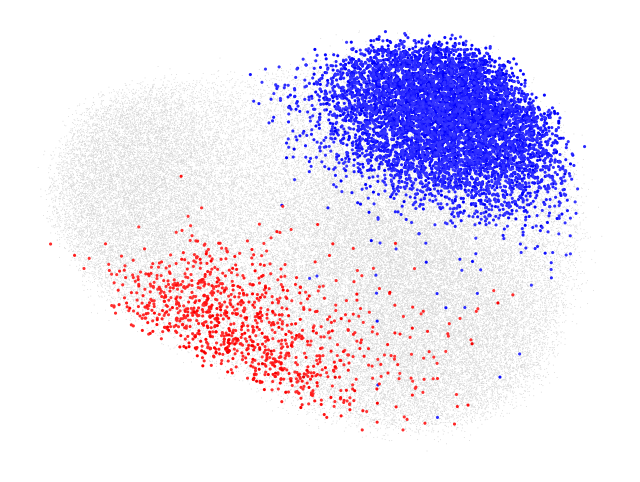

In [67]:
plt.figure(figsize=(8,6))
sc.pl.umap(d, ax=plt.gca(), frameon=False, show=False)
sc.pl.umap(d[d.obs.ncorr_thresh != 0], color='ncorr_thresh', cmap='seismic', s=20, vmin=-1, vmax=1, ax=plt.gca(),
           frameon=False, colorbar_loc=None, show=False, title='')
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

In [32]:
Ddense.samplem['npatches'] = Ddense.obs.sid.value_counts()
Ddense.samplem[['nneg', 'npos']] = pd.crosstab(Ddense.obs.sid, Ddense.obs.ncorr_thresh.map(
                                    lambda x: 0 if x < 0 else (1 if x > 0 else np.nan)
                                ))
Ddense.samplem[['nneg', 'npos']] = Ddense.samplem[['nneg', 'npos']].fillna(0)

> /Users/yakir/Dropbox/py/tpae/vis.py(223)diff_markers()
    221     df.loc[neg_set, 'status'] = labels[1]
    222     import pdb; pdb.set_trace()
--> 223     sns.violinplot(data=df, x='marker', y='value', hue='status')
    224     plt.ylabel('level')
    225     if show:



ipdb>  !df


                marker  value status
0      Oligodendrocyte  155.0    NaN
1      Oligodendrocyte  161.0    NaN
2      Oligodendrocyte  151.0    NaN
3      Oligodendrocyte  159.0    NaN
4      Oligodendrocyte  161.0    NaN
...                ...    ...    ...
70893             Sncg    0.0    NaN
70894             Sncg    1.0    NaN
70895             Sncg    0.0    NaN
70896             Sncg    0.0    NaN
70897             Sncg    0.0    NaN

[708980 rows x 3 columns]


ipdb>  !df.status


0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
70893    NaN
70894    NaN
70895    NaN
70896    NaN
70897    NaN
Name: status, Length: 708980, dtype: object


ipdb>  !df.status.unique()


array([nan, 'case', 'ctrl'], dtype=object)


ipdb>  !df.status.value_counts()


status
ctrl    71090
case    10860
Name: count, dtype: int64


ipdb>  c


ValueError: cannot reindex on an axis with duplicate labels

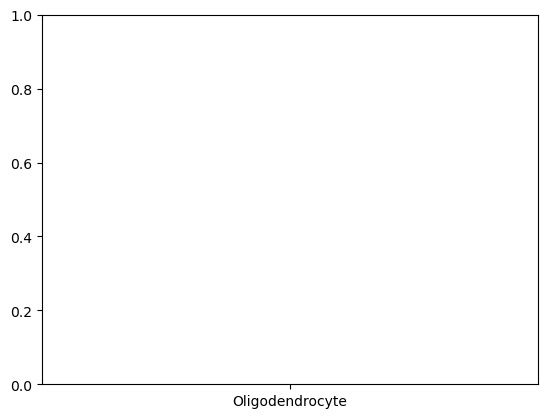

In [40]:
from importlib import reload; reload(tv)
tv.diff_markers(Ddense.obs[celltypes], Ddense.obs[Ddense.obs.ncorr_thresh > 0].index, Ddense.obs[Ddense.obs.ncorr_thresh < 0].index, celltypes,
                labels=['case','ctrl'], nmarkers=10, ascending=False, show=True)

In [62]:
from scipy.stats import ks_2samp
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y
def twosample(a, b, cdf=True):
    if cdf:
        plt.plot(*ecdf(a), label='ctrl')
        plt.plot(*ecdf(b), label='case')
    else:
        plt.hist(a, bins=10, density=True, alpha=0.5, label='ctrl')
        plt.hist(b, bins=10, density=True, alpha=0.5, label='case')
    plt.legend()
    plt.savefig('/Users/yakir/Desktop/temp.png')
    plt.show()
    return ks_2samp(a, b, alternative='greater')

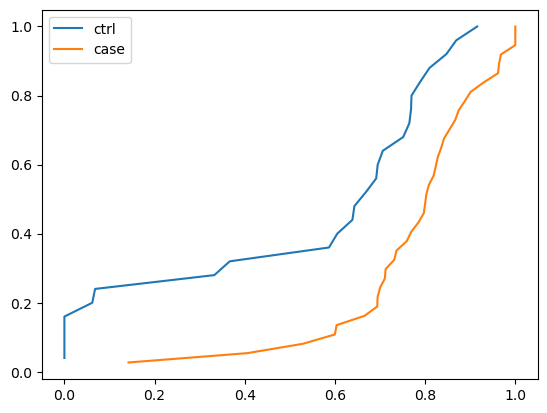

KstestResult(statistic=0.40756756756756757, pvalue=0.005035339780952033, statistic_location=0.7891760904684976, statistic_sign=1)

In [64]:
# Ddense.obs['layer6'] = Ddense.obs.L6b >= 0.05
# Ddense.obs['manyoligo'] = Ddense.obs.Oligodendrocyte >= 0.1
# Ddense.obs['layer6_manyoligo'] = Ddense.obs.layer6 * Ddense.obs.manyoligo
# Ddense.samplem['frac_layer6_manyoligo'] = Ddense.obs.groupby('sid').manyoligo.aggregate('mean')

twosample(Ddense.samplem[~Ddense.samplem.case].frac_layer6_manyoligo,
          Ddense.samplem[Ddense.samplem.case].frac_layer6_manyoligo,
         cdf=True)

In [ ]:
import scipy.stats as scstats
m = Ddense.uns['NAM.T'].T.values
m /= m.sum(axis=0)
plt.hist(scstats.entropy(m, axis=0, base=2), bins=100, alpha=0.5, density=True)
plt.axvline(x=np.log2(len(m)), color='k')

m = D.uns['NAM.T'].T.values
m /= m.sum(axis=0)
plt.hist(scstats.entropy(m, axis=0, base=2), bins=100, alpha=0.5, density=True)
plt.axvline(x=np.log2(len(m)), color='k')
plt.show()

In [ ]:
d = Ddense

In [ ]:
res = cna.tl.association(d, d.samplem['control'] != 'Checked',
                   donorids=d.samplem.donor.values, ks=[1], Nnull=100000)
res.p

In [ ]:
thresh = res.fdrs[res.fdrs.fdr <= 0.2].threshold.iloc[0]
Ddense.obs['ncorr'] = res.ncorrs
Ddense.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) >= thresh)
res.p, (Ddense.obs.ncorr_thresh != 0).sum()

In [ ]:
if res.fdrs.fdr.min() <= 0.2:
    print(f'{res.fdrs[res.fdrs.fdr < 0.2].iloc[0].num_detected} at FDR 20%')
    d.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) > res.fdrs[res.fdrs.fdr < 0.2].iloc[0].threshold)
    sc.pl.umap(d, ax=plt.gca(), show=False)
    sc.pl.umap(d[d.obs.ncorr_thresh != 0], color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1, s=5, ax=plt.gca(),
               colorbar_loc=None, show=False)
else:
    d.obs['ncorr_thresh'] = 0
plt.title('')
for s in plt.gca().spines.values():
    s.set_visible(False)
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
tv.diff_markers(d.obs, d.obs.index[d.obs.ncorr_thresh > 0],
                d.obs.index[d.obs.ncorr_thresh <= 0], celltypes,
                labels=['Dementia', 'Rest'], nmarkers=5); plt.show()
plt.figure(figsize=(12,4))
tv.diff_markers(d.obs, d.obs.index[d.obs.ncorr_thresh < 0],
                d.obs.index[d.obs.ncorr_thresh >= 0], celltypes,
                labels=['Control', 'Rest'], nmarkers=5); plt.show()

In [ ]:
plt.imshow(np.corrcoef(d.obs[celltypes].T, d.obs.ncorr_thresh > 0), cmap='seismic', vmin=-1, vmax=1)
plt.yticks(range(len(celltypes)), celltypes)
plt.show()

In [129]:
(d.samplem.npos >= 10).sum()

25

.........................

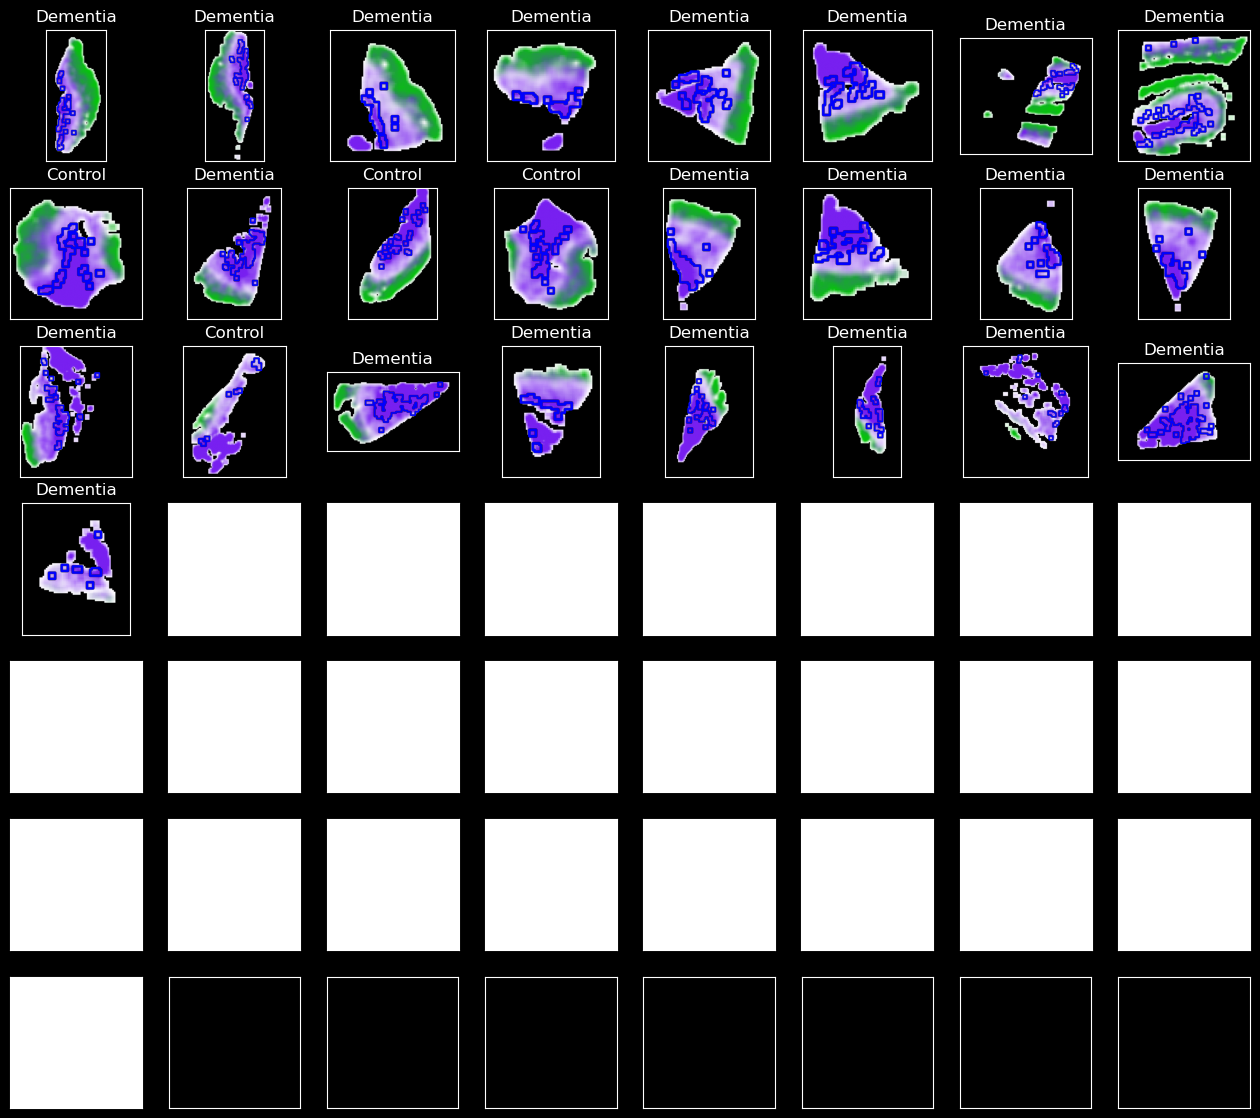

In [130]:
from importlib import reload; reload(tv)
d.samplem['yhat'] = res.yresid_hat
tv.spatialplot(samples,
               d.samplem[d.samplem.npos >= 10].yhat,
               d.obs,
               [d.obs['L2/3 IT'], d.obs['Oligodendrocyte']],#d.obs['L6b']*5,],
               rgbs=[[0.,0.8,0.],[120/255., 32/255., 240/255.],[0, 0.5, 0.5]],
               labels=d.samplem.control.map({'Checked':'Control','Unchecked':'Dementia'}),
               highlight=d.obs.ncorr_thresh > 0,
               outline_rgba=[0,0,1,1], outline_thickness=15,
               skipthresh=200, skipevery=1,
               vmax=5, ncols=8, size=2, show=False)
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

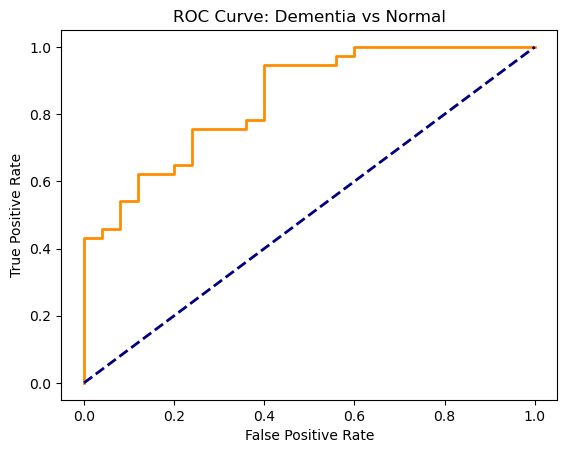

AUROC: 0.85


In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(d.samplem.control == 'Unchecked', d.samplem.yhat)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Dementia vs Normal")
plt.show()

# Print the AUROC value
print(f"AUROC: {roc_auc:.2f}")

# Scratch

In [35]:
d.obs['PC1'] = d.uns['NAM_nbhdXpc'].PC1
celltypes = d.obs.columns[9:]

In [36]:
d.obs['totalcells'] = d.obs[celltypes].sum(axis=1)

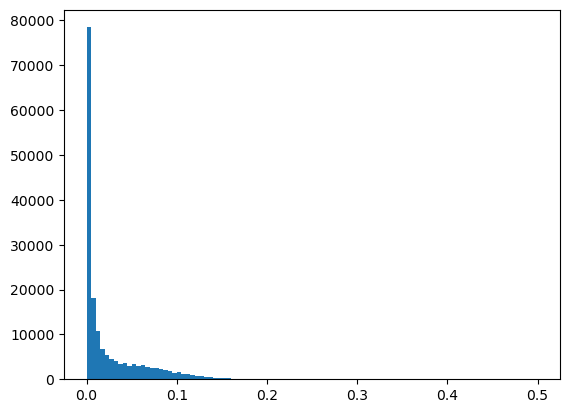

In [42]:
plt.hist(d.obs.L6b / d.obs.totalcells, bins=100); plt.show()

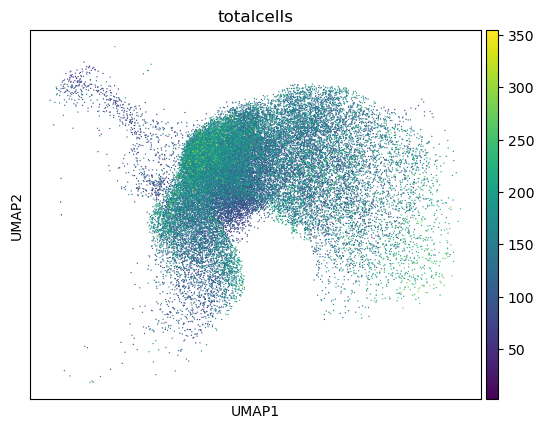

In [44]:
sc.pl.umap(d[d.obs.L6b / d.obs.totalcells > 0.05], color='totalcells')

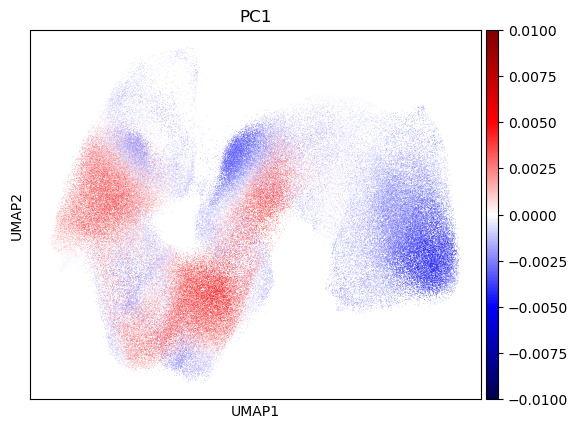

In [27]:
sc.pl.umap(d, color='PC1', vmin=-.01, vmax=.01, cmap='seismic')

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.scatterplot(x=Ddense.uns['NAM_sampleXpc'].PC1, y=Ddense.uns['NAM_sampleXpc'].PC2,
                # hue=Ddense.samplem.donor,
                hue=Ddense.samplem['Consensus Clinical Dx (choice=Control)'],
                palette='Set1')
plt.show()

In [ ]:
Ddense.samplem['yhat'] = res.yresid_hat

In [ ]:
d = Ddense
fig, axs = plt.subplots(8,8, figsize=(8/8*10,10))
i = 0
for sid in d.samplem.yhat.sort_values().index:
    mypatches = d[(d.obs.sid == sid)]
    mysigpatches = d[(d.obs.sid == sid)&(d.obs.ncorr_thresh != 0)]
    canvas = np.zeros_like(samples[sid][:,:,0])
    sigcanvas = np.zeros_like(samples[sid][:,:,0])
    for x,y,ps in mypatches.obs[['x','y','patchsize']].values:
        canvas[y:y+ps,x:x+ps] = 1
    for x,y,ps,nc in mysigpatches.obs[['x','y','patchsize','ncorr']].values:
        x,y,ps = int(x), int(y), int(ps)
        sigcanvas[y:y+ps,x:x+ps] += nc
    sigcanvas[sigcanvas == 0] = np.NaN
    indices = np.where(canvas)
    nonempty_rows = canvas.sum(axis=1) > 0
    nonempty_cols = canvas.sum(axis=0) > 0
    if (~np.isnan(sigcanvas)).sum() > 0:
        ax = axs.flatten()[i]; i += 1
        ax.imshow(canvas[nonempty_rows][:,nonempty_cols], vmin=0, vmax=1, cmap='gray')
        ax.imshow(sigcanvas[nonempty_rows][:,nonempty_cols], vmin=-10, vmax=10, cmap='seismic')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.set_tick_params(length=0)
        ax.yaxis.set_tick_params(length=0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # ax.set_title(d.samplem.idxmax(axis=1)[sid], color='white', fontsize=16)
fig.patch.set_facecolor('black')
plt.show()

In [ ]:
np.where(groups == groups[0])[0]

In [ ]:
[y[groups == g][0] for g in np.unique(groups)]

In [ ]:
import statsmodels.api as sm
def shuffle_group_labels(y, groups, Nnull):
    df = pd.DataFrame({'y': y, 'group': groups})
    unique_groups = df.drop_duplicates('group')  # One row per unique group
    group_values = unique_groups['y'].values  # Unique y values
    
    shuffled_vectors = []
    for _ in range(Nnull):
        shuffled_values = group_values.copy()  # Copy original unique group values
        np.random.shuffle(shuffled_values)     # Shuffle the group values
        shuffled_y = df['group'].map(dict(zip(unique_groups['group'], shuffled_values)))  # Map shuffled values to groups
        shuffled_vectors.append(shuffled_y.values)  # Store shuffled result
    return np.array(shuffled_vectors)

def linearR2(y, X, w):
    X = sm.add_constant(X)
    cov = X.T.dot(X*w[:,None])
    beta = np.linalg.solve(cov, X.T.dot(w*y))
    yhat = X.dot(beta)
    return np.corrcoef(y, yhat)[0,1]

def ridge_reg(y, X, groups, lambd, w):
    X = sm.add_constant(X)
    i = X.shape[1]
    X = np.hstack([X, pd.get_dummies(groups).values.astype('float')])
    cov = X.T.dot(X*w[:,None])
    ridge = np.zeros(X.shape[1])
    ridge[i:] = lambd
    cov += np.diag(ridge)
    beta = np.linalg.solve(cov + np.diag(ridge), X.T.dot(w*y))
    yhat = X.dot(beta)
    return np.corrcoef(y, yhat)[0,1]

In [ ]:
d = Ddense
d.samplem = pd.merge(samplemeta, d.obs[['sid','donor']].drop_duplicates(),
         left_index=True, right_on='donor', how='right').set_index('sid')
cna.tl.nam(d)
data = pd.merge(d.samplem, d.uns['NAM_sampleXpc'], left_index=True, right_index=True, how='right')
donor_counts = data['donor'].value_counts()
data['weight'] = data['donor'].map(lambda donor: 1 / donor_counts[donor])
y = (data['Consensus Clinical Dx (choice=Control)'] == 'Checked').astype('float').values
X = data[['PC1']].values
w = data.weight.values
groups = data.loc[:, 'donor'].values
r = linearR2(y, X, w)
# r = ridge_reg(y, X, groups, lambd, w)
null_dist = np.array([
    linearR2(y_, X, w) for y_ in shuffle_group_labels(y, groups, 10000)
    # ridge_reg(y_, X, groups, lambd, w) for y_ in shuffle_group_labels(y, groups, 10000)
])
((null_dist >= r).sum() + 1)/(len(null_dist)+1)

In [ ]:
def weighted_mean(values, weights):
    return np.sum(weights * values) / np.sum(weights)

def weighted_covariance(x, y, weights):
    x_mean = weighted_mean(x, weights)
    y_mean = weighted_mean(y, weights)
    return np.sum(weights * (x - x_mean) * (y - y_mean)) / np.sum(weights)

def weighted_std(values, weights):
    mean = weighted_mean(values, weights)
    return np.sqrt(np.sum(weights * (values - mean) ** 2) / np.sum(weights))

def weighted_correlation(x, y, weights):
    cov_xy = weighted_covariance(x, y, weights)
    std_x = weighted_std(x, weights)
    std_y = weighted_std(y, weights)
    return cov_xy / (std_x * std_y)

fancycorrs = np.array([weighted_correlation(nbhd, y, w) for nbhd in NAM.T])
null_fancycorrs = null_corrs = np.array([
    [weighted_correlation(nbhd, y_, w) for nbhd in NAM.T]
    for y_ in shuffle_group_labels(y, groups, 1000)
])

In [ ]:
NAM = d.uns['NAM.T'].T.values
NAM_ = NAM - NAM.mean(axis=0)
NAM_ = NAM_ / NAM_.std(axis=0)
corrs = NAM_.T.dot(y - y.mean()) / (y.std() * len(y))

In [ ]:
null_corrs = np.array([
    NAM_.T.dot(y_ - y_.mean()) / y_.std() / len(y_) for y_ in shuffle_group_labels(y, groups, 1000)
])

In [ ]:
maxcorr = np.abs(fancycorrs).max()
fdr_thresholds = np.arange(maxcorr/4, maxcorr, maxcorr/400)
fdr_vals = cna.tl._stats.empirical_fdrs(fancycorrs, null_fancycorrs.T, fdr_thresholds)

In [ ]:
fdrs = pd.DataFrame({
            'threshold':fdr_thresholds,
            'fdr':fdr_vals,
            'num_detected': [(np.abs(corrs)>t).sum() for t in fdr_thresholds]})

In [ ]:
fdrs[fdrs.fdr <= 0.2]

In [ ]:
d.obs['ncorrs'] = corrs
d.obs['ncorrs_thresh'] = corrs * (np.abs(corrs) > fdrs[fdrs.fdr <= 0.2].threshold.iloc[0])

In [ ]:
sc.pl.umap(d, color='ncorrs_thresh', cmap='seismic')

In [ ]:
sc.tl.leiden(Ddense, resolution=1)
sc.pl.umap(Ddense, color='leiden')

In [ ]:
d = Ddense
for s in d.obs.sid.unique():
    toplot = d.obs[d.obs.sid == s]
    plt.scatter(toplot.x+20, toplot.y+20, c=toplot.leiden.astype(int), s=10)
    plt.show()

In [ ]:
Ddense_pca = ta.anndata(Pdense.meta,
               Z.reshape((len(Z), -1)),
               samplemeta,
               sampleid='donor',
               use_rep='X_pca', n_comps=20)
sc.pl.umap(Ddense_pca, color='donor')
Ddense_pca.samplem = Ddense.samplem.loc[Ddense.obs.donor.unique()]

In [ ]:
# Z = ta.apply(model, Pdense, embedding=model.penultimate_layer)
Ddense_avg = ta.anndata(Pdense.meta,
               Z.mean(axis=(2,3)),
               samplemeta,
               sampleid='donor',
               use_rep='X_pca', n_comps=20)
sc.pl.umap(Ddense_avg, color='donor')
Ddense_avg.samplem = Ddense.samplem.loc[Ddense.obs.donor.unique()]

In [ ]:
Zcov = np.array([z.dot(z.T)[np.triu_indices(64)] for z in Z.reshape((len(Z), 64, -1))])
Ddense_cov = ta.anndata(Pdense.meta,
               Zcov,
               samplemeta,
               sampleid='donor',
               use_rep='X_pca', n_comps=20)
sc.pl.umap(Ddense_cov, color='donor')
Ddense_cov.samplem = Ddense.samplem.loc[Ddense.obs.donor.unique()]

In [ ]:
d = Ddense_avg
# d.samplem = d.samplem.set_index('donor'); d.sampleid = 'donor'
pheno = 'Consensus Clinical Dx (choice=Control)'
cna.tl.nam(d, force_recompute=True)
plt.scatter(d.uns['NAM_sampleXpc'].PC1, d.uns['NAM_sampleXpc'].PC2, s=20)
plt.show()

res = cna.tl.association(d, d.samplem[pheno] == 'Checked', Nnull=10000, ks=[1])
print(f'P = {res.p}, used {res.k} PCs')
d.obs['ncorr'] = res.ncorrs
if res.fdrs.fdr.min() <= 0.2:
    print(f'{res.fdrs[res.fdrs.fdr < 0.2].iloc[0].num_detected} at FDR 20%')
    d.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) > res.fdrs[res.fdrs.fdr < 0.2].iloc[0].threshold)
    # d.obs['fstar'] = pd.merge(d.obs[['donor']], d.samplem[['fstar']], left_on='donor', right_index=True, how='left').fstar
    # sc.pl.umap(d, color='ncorr', cmap='seismic', vmin=-1, vmax=1, ax=plt.gca(), show=False, colorbar_loc=None)
    sc.pl.umap(d, ax=plt.gca(), show=False)
    sc.pl.umap(d[d.obs.ncorr_thresh != 0], color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1, s=30, ax=plt.gca(),
               colorbar_loc=None, show=False)
else:
    d.obs['ncorr_thresh'] = 0
plt.title('')
plt.show()

In [ ]:
d = Ddense_
d.samplem = pd.merge(d.samplem, d.obs[['sid','donor']].drop_duplicates(),
         left_index=True, right_on='donor', how='right').drop(columns=['donor_y']).set_index('sid', drop=True)
cna.tl.nam(d, force_recompute=True)

In [ ]:
ridge_reg(y, data[['PC1']].values, groups, 1)

In [ ]:
y = (data['Consensus Clinical Dx (choice=Control)'] == 'Checked').astype('float').values
X = data[['PC1']].values
groups = data.loc[:, 'donor'].values
r2 = linearR2(y, X)
null_dist = np.array([
    linearR2(y_, X) for y_ in shuffle_group_labels(y, groups, 10000)
])
((null_dist >= r2).sum() + 1)/(10001)

In [ ]:
y = (data['Consensus Clinical Dx (choice=Control)'] == 'Checked').astype('float').values
X = data[['PC1']].values
groups = data.loc[:, 'donor'].values
lambd = 1000000
r2 = ridge_reg(y, X, groups, lambd)
null_dist = np.array([
    ridge_reg(y_, X, groups, lambd) for y_ in shuffle_group_labels(y, groups, 10000)
])
((null_dist >= r2).sum() + 1)/(len(null_dist)+1)

In [ ]:

fixed = sm.add_constant(data[['PC1']])
fixed_null = fixed[['const']].values
fixed = fixed.values
groups = data.loc[:, 'donor'].values
# y = data['PC1'].values
# fixed = sm.add_constant((data['Consensus Clinical Dx (choice=Control)'] == 'Checked').astype('float').values)
# fixed_null = fixed[:,:1]
# groups = data.loc[:, 'donor'].values

null = MixedLM(y, fixed_null, groups=groups).fit(reml=False)
llf1 = null.llf

full = MixedLM(y, fixed, groups=groups).fit(reml=False)
llf2 = full.llf
lrt_statistic = -2 * (llf1 - llf2)
df = 1
pval = chi2.sf(lrt_statistic, df)
pval

In [ ]:
null.params

In [ ]:
from pandas.api.types import is_numeric_dtype
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy.stats import chi2

data = pd.merge(d.samplem, d.uns['NAM_sampleXpc'], left_index=True, right_index=True, how='right')
random_vars = ['donor']
response = 'PC1'

min_donors = 20
min_donors_case = 10
res_all = pd.DataFrame()
np.random.seed(0)
for c in d.samplem.iloc[:, 1:]:
    print(c)
    c_cat = c

    if not is_numeric_dtype(d.samplem[c]):
        contrast_df = pd.get_dummies(data[c_cat])
        
        for c in contrast_df.columns:
            if contrast_df[c].var() == 0:
                continue
        
            fixed_effects = sm.add_constant(contrast_df[c].astype('int'))  
            ind = fixed_effects.dropna().index
            n_samples = len(ind)
            n_donors = len(data.loc[ind, random_vars].iloc[:, 0].unique())
        
            if ((len(data.loc[ind, 'donor'][data.loc[ind, c_cat]==c].unique())<min_donors_case) or 
                (len(data.loc[ind, 'donor'][data.loc[ind, c_cat]!=c].unique())<min_donors_case) or
                len(data.loc[ind, 'donor'].unique())<min_donors):
                continue

            fixed_effects_null = pd.DataFrame(sm.add_constant(contrast_df).iloc[:, 0]) 
            remodel = MixedLM(data.loc[ind, response], fixed_effects_null.loc[ind,:], groups=data.loc[ind, random_vars].iloc[:, 0])
            null = remodel.fit(reml= False)
            llf1 = null.llf

            remodel = MixedLM(data.loc[ind, response], fixed_effects.loc[ind,: ], groups=data.loc[ind, random_vars].iloc[:, 0])
            full = remodel.fit(reml= False)
            llf2 = full.llf
            lrt_statistic = -2 * (llf1 - llf2)
            df = 1
            pval = chi2.sf(lrt_statistic, df)
            print(full.summary())

            res_all = pd.concat([res_all, 
                         pd.DataFrame([c_cat, c, pval, full.params[c], full.pvalues[c], full.bse[c], full.tvalues[c],
                                      n_samples, n_donors]).T])

    else:
        fixed_effects = sm.add_constant(data[c])
        ind = fixed_effects.dropna().index
        n_samples = len(ind)
        n_donors = len(data.loc[ind, random_vars].iloc[:, 0].unique())
        
        if len(data.loc[ind, 'donor'].unique())<min_donors:
            continue

        fixed_effects_null = pd.DataFrame(sm.add_constant(data).iloc[:, 0]) 
        remodel = MixedLM(data.loc[ind, response], fixed_effects_null.loc[ind,:], groups=data.loc[ind, random_vars].iloc[:, 0])
        null = remodel.fit(reml= False)
        llf1 = null.llf

        remodel = MixedLM(data.loc[ind, response], fixed_effects.loc[ind,: ], groups=data.loc[ind, random_vars].iloc[:, 0])
        full = remodel.fit(reml= False)
        llf2 = full.llf
        lrt_statistic = -2 * (llf1 - llf2)
        df = 1
        pval = chi2.sf(lrt_statistic, df)
        print(full.summary())

        res_all = pd.concat([res_all, 
                     pd.DataFrame([c_cat, c, pval, full.params[c], full.pvalues[c], full.bse[c], full.tvalues[c],
                                  n_samples, n_donors]).T])
    
res_all.columns = ['var', 'dummy_var', 'pval_LRT', 'coef', 'pval_T', 'std_err', 'z', 'n_samples',
                  'n_donors']
res_all = res_all.reset_index(drop = True)

In [ ]:
res_all.sort_values(by='pval_LRT')

In [ ]:
from statutils import vis
vis.qqplot(res_all.pval_LRT.values.astype('float'))
plt.show()

In [ ]:
fig, axs = plt.subplots(3,8, figsize=(8/3*10,10))
i = 0
for donor in d.uns['NAM_sampleXpc'].PC1.sort_values().index:
    for sid in d.obs[d.obs.donor == donor].sid.unique()[:1]:
        mypatches = d[(d.obs.sid == sid)]
        mysigpatches = d[(d.obs.sid == sid)&(d.obs.ncorr_thresh != 0)]
        canvas = np.zeros_like(samples[sid][:,:,0])
        sigcanvas = np.zeros_like(samples[sid][:,:,0])
        for x,y,ps in mypatches.obs[['x','y','patchsize']].values:
            canvas[y:y+ps,x:x+ps] = 1
        for x,y,ps,nc in mysigpatches.obs[['x','y','patchsize','ncorr']].values:
            x,y,ps = int(x), int(y), int(ps)
            sigcanvas[y:y+ps,x:x+ps] += nc
        sigcanvas[sigcanvas == 0] = np.NaN
        indices = np.where(canvas)
        nonempty_rows = canvas.sum(axis=1) > 0
        nonempty_cols = canvas.sum(axis=0) > 0
        if (~np.isnan(sigcanvas)).sum() > 0:
            ax = axs.flatten()[i]; i += 1
            ax.imshow(canvas[nonempty_rows][:,nonempty_cols], vmin=0, vmax=1, cmap='gray')
            ax.imshow(sigcanvas[nonempty_rows][:,nonempty_cols], vmin=-10, vmax=10, cmap='seismic')
            ax.spines['top'].set_color('white')
            ax.spines['bottom'].set_color('white')
            ax.spines['left'].set_color('white')
            ax.spines['right'].set_color('white')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.xaxis.set_tick_params(length=0)
            ax.yaxis.set_tick_params(length=0)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_title(d.samplem.idxmax(axis=1)[donor], color='white', fontsize=16)
fig.patch.set_facecolor('black')
plt.show()